## Python3, pytorch 1.4 버전으로 변환

* 출처 :  https://github.com/Duncanswilson/maxout-pytorch


## 수정 사항

*  IndexError: invalid index of a 0-dim tensor. Use tensor.item() to convert a 0-dim tensor to a Python number
    - `loss.data[0]` -> `loss.data.item()`
    - `F.log_softmax(x)` -> `F.log_softmax(x, dim=1)`

## Maxout Networks in Pytorch 

This notebook is an implementation of maxout units (https://arxiv.org/abs/1302.4389) in Pytorch. My primary motivation of this was to ensure that I actually understood what maxout units were, as I found most explanations available quite opaque or incorrect! 

In [1]:
import numpy as np 
import torch 
import torch.nn as nn 
from torchvision import datasets, transforms 
from torch.autograd import Variable 
from torch.nn import init
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 

Below we define a custom object so we can have models which contain objects which behave like lists while holding multiple modules. This is needed as we're going to store lists of layers per maxout unit. 

In [2]:
class ListModule(object):
    def __init__(self, module, prefix, *args):
        self.module = module
        self.prefix = prefix
        self.num_module = 0
        for new_module in args:
            self.append(new_module)

    def append(self, new_module):
        if not isinstance(new_module, nn.Module):
            raise ValueError('Not a Module')
        else:
            self.module.add_module(self.prefix + str(self.num_module), new_module)
            self.num_module += 1

    def __len__(self):
        return self.num_module

    def __getitem__(self, i):
        if i < 0 or i >= self.num_module:
            raise IndexError('Out of bound')
        return getattr(self.module, self.prefix + str(i))

In [3]:
learning_rate = 0.0001
batch_size = 50
n_epochs = 3
cuda = torch.cuda.is_available()

The magic normalization numbers below are actually the mean and the std of the training set of MNIST, hardcoded to save compute each run. 

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                       ])),
                       batch_size=batch_size, shuffle=True)

In [5]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                       ])),
                       batch_size=batch_size, shuffle=True)

### What is Maxout? 
Maxout is a piece of a deep learning model that sits somewhere between an activation function and a layer. It computes a nonlinearity (namely the max function) but also has learnable parameters. For reference, it is generally considered an activation but I find that terminology troublesome as it forces there to be multiple layers to max over. `¯\_(ツ)_/¯`

In their paper, Goodfellow et. al. describe the maxout activation as: 

$$h_i = max_{j \in [1,k]} z_{i,j}$$

where $h_i$ is the hidden layer output and $z = x^TW_{\cdots i,j} + b_{i,j}$ , where $x$ could be the input or the output of the previous layer. 


I find this description incredibly confusing and for a while I thought that all that you did for maxout was to compute a linear layer, group into k groups, and take the max over those groups. (the use of $k$ in the indices above should give you a hint that this interpretation is wrong) Alas, Karpathy was to the rescue here: http://cs231n.github.io/neural-networks-1/

The tldr; is that a maxout unit is an element-wise max _over_ multiple linear (or convolutional/other) layers, so for a maxout layer with two units it is computed, like so: 
$max\{W_1^Tx +b_1, W_2^Tx + b_2\}$

so in the case where $W_2^Tx+b_2 = 0$ we see that the maxout layer is a ReLU. For other properties about maxout nets, we refer back to Goodfellow's paper. 

### Define Models 
Here we define the two classes of models to test the maxout network against. 

We have an MLP and ConvNet using just ReLU's and the maxout equivalent of those networks. 

Note that for each layer which uses a maxout we have $lu$ total parameters, where $l$ is the number of parameters per unit and $u$ is the number of units. 

In [6]:
class rectifier_mlp(nn.Module):
    def __init__(self):
        super(rectifier_mlp, self).__init__()
        self.fc1 = nn.Linear(784, 1024)
        self.fc2 = nn.Linear(1024, 10)


    def forward(self, x): 
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [7]:
class maxout_mlp(nn.Module):
    def __init__(self, num_units=2):
        super(maxout_mlp, self).__init__()
        self.fc1_list = ListModule(self, "fc1_")
        self.fc2_list = ListModule(self, "fc2_")
        for _ in range(num_units):
            self.fc1_list.append(nn.Linear(784, 1024))
            self.fc2_list.append(nn.Linear(1024, 10))

    def forward(self, x): 
        x = x.view(-1, 784)
        x = self.maxout(x, self.fc1_list)
        x = F.dropout(x, training=self.training)
        x = self.maxout(x, self.fc2_list)
        return F.log_softmax(x)

    def maxout(self, x, layer_list):
        max_output = layer_list[0](x)
        for _, layer in enumerate(layer_list, start=1):
            max_output = torch.max(max_output, layer(x))
        return max_output
                            

In [8]:
class rectifier_conv_net(nn.Module):
    def __init__(self):
        super(rectifier_conv_net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc2 = nn.Linear(1024, 10)


    def forward(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        #return F.log_softmax(x)
        return F.log_softmax(x, dim=1)

In [9]:
class maxout_conv_net(nn.Module):
    def __init__(self, num_units=2):
        super(maxout_conv_net, self).__init__()
        self.conv1_list = ListModule(self, "conv1_")
        self.conv2_list = ListModule(self, "conv2_")
        self.fc1_list = ListModule(self, "fc1_")
        self.fc2_list = ListModule(self, "fc2_")
        for _ in range(num_units):
            self.conv1_list.append(nn.Conv2d(1, 32, 5, padding=2))
            self.conv2_list.append(nn.Conv2d(32, 64, 5, padding=2))
            self.fc1_list.append(nn.Linear(64*7*7, 1024))
            self.fc2_list.append(nn.Linear(1024, 10))

    def forward(self, x): 
        x = F.max_pool2d(self.maxout(x, self.conv1_list), 2)
        x = F.max_pool2d(self.maxout(x, self.conv2_list), 2)
        x = x.view(-1, 64*7*7)
        x = self.maxout(x, self.fc1_list)
        x = F.dropout(x, training=self.training)
        x = self.maxout(x, self.fc2_list)
        #return F.log_softmax(x)
        return F.log_softmax(x, dim=1)

    def maxout(self, x, layer_list):
        max_output = layer_list[0](x)
        for _, layer in enumerate(layer_list, start=1):
            max_output = torch.max(max_output, layer(x))
        return max_output
                            

In [10]:
def train(epoch,  net, train_loss, train_acc): 
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader): 
        if cuda:
            data, target = Variable(data).cuda(0), Variable(target).cuda(0)
        else:
            data, target = Variable(data), Variable(target)
            
        optimizer.zero_grad()
        output = net(data)
        loss = F.cross_entropy(output, target)
        #IndexError: invalid index of a 0-dim tensor. Use tensor.item() to convert a 0-dim tensor to a Python number
        #print('loss.data=', loss.data)
        #print('loss.data[0]=', loss.data[0])
        #print('loss.data[0].item()=', loss.data[0].item())
        #print('loss.data.item()=', loss.data.item())
        train_loss.append(loss.data.item())
        loss.backward()
        optimizer.step()
        prediction = output.data.max(1)[1]
        accuracy = prediction.eq(target.data).sum()*1.0/batch_size*100.0 
        train_acc.append(accuracy)
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [11]:
def test(epoch, net):
    net.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        # volatile = True -> torch.no_grad(), torch.set_grad_enabled(False)
        # data, target = Variable(data, volatile=True), Variable(target)
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
        
        # or
        # x = torch.tensor([1., 2., 3.], requires_grad=False)
        # x = torch.randn(1, requires_grad=False)
        # x = torch.randn(1)
        # x.requires_grad_(False)

        output = net(data)
        #test_loss += F.cross_entropy(output, target).data[0]
        test_loss += F.cross_entropy(output, target).data.item()
        
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(test_loader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [12]:
if cuda:
    net_relu = rectifier_conv_net().cuda()
else:
    net_relu = rectifier_conv_net()
relu_loss = [] 
relu_acc = []
for epoch in range(n_epochs): 
    train(epoch, net_relu, relu_loss, relu_acc)
    test(epoch, net_relu)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.293872
Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.486186
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.244505
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.198972
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.419164
Train Epoch: 0 [25000/60000 (42%)]	Loss: 0.197916
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.188678
Train Epoch: 0 [35000/60000 (58%)]	Loss: 0.146414
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.052304
Train Epoch: 0 [45000/60000 (75%)]	Loss: 0.055076
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.199062
Train Epoch: 0 [55000/60000 (92%)]	Loss: 0.024454

Test set: Average loss: 0.0676, Accuracy: 9781/10000 (98%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.051491
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.213650
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.024040
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.141894
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.045680
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.015352
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.014407
Tra

In [13]:
if cuda:
    net_maxout = maxout_conv_net(num_units=5).cuda() #this uses 5 "maxout units" per "layer" 
else:
    net_maxout = maxout_conv_net(num_units=5)
maxout_loss = [] 
maxout_acc = []
for epoch in range(n_epochs): 
    train(epoch, net_maxout, maxout_loss, maxout_acc)
    test(epoch, net_maxout)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.459123
Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.457375
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.320488
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.131100
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.062956
Train Epoch: 0 [25000/60000 (42%)]	Loss: 0.085650
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.173089
Train Epoch: 0 [35000/60000 (58%)]	Loss: 0.053249
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.037328
Train Epoch: 0 [45000/60000 (75%)]	Loss: 0.088467
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.082980
Train Epoch: 0 [55000/60000 (92%)]	Loss: 0.040334

Test set: Average loss: 0.0451, Accuracy: 9858/10000 (99%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.010436
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.268595
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.054502
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.016731
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.026272
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.178027
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.060788
Tra

In [14]:
if cuda:
    mlp_relu = rectifier_mlp().cuda() 
else:
    mlp_relu = rectifier_mlp()
relu_mlp_loss = [] 
relu_mlp_acc = []
for epoch in range(n_epochs): 
    train(epoch, mlp_relu, relu_mlp_loss, relu_mlp_acc)
    test(epoch, mlp_relu)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.334240
Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.621176
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.504858
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.234004
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.410078
Train Epoch: 0 [25000/60000 (42%)]	Loss: 0.484776
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.250572
Train Epoch: 0 [35000/60000 (58%)]	Loss: 0.303225
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.136777
Train Epoch: 0 [45000/60000 (75%)]	Loss: 0.355186
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.227033
Train Epoch: 0 [55000/60000 (92%)]	Loss: 0.226823

Test set: Average loss: 0.2154, Accuracy: 9380/10000 (94%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.491668
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.211445
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.271891
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.118838
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.074286
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.243088
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.158975
Tra

In [15]:
if cuda:
    mlp_maxout = maxout_mlp(num_units=5).cuda() 
else:
    mlp_maxout = maxout_mlp(num_units=5)
maxout_mlp_loss = [] 
maxout_mlp_acc = []
for epoch in range(n_epochs): 
    train(epoch, mlp_maxout, maxout_mlp_loss, maxout_mlp_acc)
    test(epoch, mlp_maxout)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.403947


/home/user/anaconda3/envs/py36torch/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.638917
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.350771
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.224627
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.365696
Train Epoch: 0 [25000/60000 (42%)]	Loss: 0.288055
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.430584
Train Epoch: 0 [35000/60000 (58%)]	Loss: 0.077642
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.216512
Train Epoch: 0 [45000/60000 (75%)]	Loss: 0.121299
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.147157
Train Epoch: 0 [55000/60000 (92%)]	Loss: 0.236515

Test set: Average loss: 0.1381, Accuracy: 9616/10000 (96%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.139839
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.177393
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.160947
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.285085
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.138454
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.199130
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.087535
Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.27904

## Plots! 
Here I show the accuracy and loss of both the MLP and the ConvNet versions of the ReLU and maxout nets. 

These plots aren't incredibly informative as MNIST is so easy that both nets do very well quickly. That said, it is clear from the plots and numbers above that the maxout network is doing better than the ReLU net. 

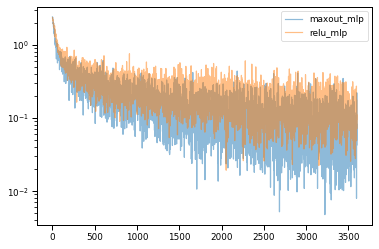

In [16]:
sns.set_context("paper")
plot1, = plt.plot(maxout_mlp_loss, label='maxout_mlp', alpha=0.5)
plt.yscale('log') # {"linear", "log", "symlog", "logit", ...}
plot2, = plt.plot(relu_mlp_loss, label='relu_mlp', alpha=0.5)
plt.yscale('log')
plt.legend(handles=[plot1, plot2])


In [17]:
[x.detach().cpu().numpy()/100 for x in maxout_mlp_acc]

[0.08,
 0.09999999046325683,
 0.08,
 0.16,
 0.19999998092651367,
 0.16,
 0.18,
 0.36,
 0.42,
 0.36,
 0.32,
 0.36,
 0.56,
 0.42,
 0.38,
 0.45999996185302733,
 0.56,
 0.48,
 0.58,
 0.68,
 0.64,
 0.78,
 0.52,
 0.64,
 0.74,
 0.52,
 0.64,
 0.68,
 0.7,
 0.76,
 0.66,
 0.64,
 0.78,
 0.7,
 0.78,
 0.66,
 0.68,
 0.62,
 0.74,
 0.72,
 0.7,
 0.72,
 0.76,
 0.78,
 0.7,
 0.9,
 0.9,
 0.7999999237060547,
 0.82,
 0.9199999237060547,
 0.76,
 0.78,
 0.82,
 0.88,
 0.78,
 0.8599999237060547,
 0.7,
 0.76,
 0.82,
 0.8599999237060547,
 0.76,
 0.82,
 0.84,
 0.76,
 0.88,
 0.7999999237060547,
 0.82,
 0.78,
 0.78,
 0.84,
 0.78,
 0.84,
 0.82,
 0.7999999237060547,
 0.74,
 0.8599999237060547,
 0.7999999237060547,
 0.82,
 0.84,
 0.7999999237060547,
 0.8599999237060547,
 0.8599999237060547,
 0.78,
 0.9,
 0.76,
 0.78,
 0.84,
 0.84,
 0.9,
 0.74,
 0.82,
 0.8599999237060547,
 0.8599999237060547,
 0.7999999237060547,
 0.9199999237060547,
 0.8599999237060547,
 0.9,
 0.84,
 0.8599999237060547,
 0.82,
 0.82,
 0.78,
 0.9199999237

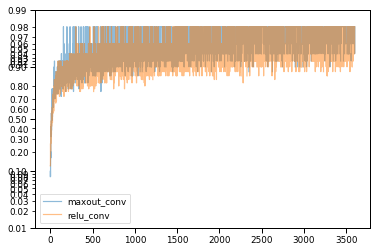

In [18]:
#plot1, = plt.plot(np.arange(len(maxout_mlp_acc)), maxout_mlp_acc, label='maxout_conv', alpha=0.5)
plot1, = plt.plot(np.arange(len(maxout_mlp_acc)), 
                  [x.detach().cpu().numpy()/100 for x in maxout_mlp_acc], 
                  label='maxout_conv', alpha=0.5)
plt.yscale('logit')
#plot2, = plt.plot(np.arange(len(relu_mlp_acc)), relu_mlp_acc, label='relu_conv', alpha=0.5)
plot2, = plt.plot(np.arange(len(relu_mlp_acc)), 
                  [x.detach().cpu().numpy()/100 for x in relu_mlp_acc],
                  label='relu_conv', alpha=0.5)
plt.yscale('logit')
plt.ylim(top=0.99, bottom=0.01)
plt.legend(handles=[plot1, plot2])


## Conclusion 

Maxout units are cool! I'm interested to see how much of an improvement these make on lower dimensional linear layers at the end of large convolutional nets and will be testing that in the coming weeks. The lack of saturation might help gradients back prop, while not requiring that you have many times more parameters for you entire model. 

This work also made me realize viscerally how important clear explanations are! There are *so many* incorrect implementations that you can find online of maxout units, so hopefully this will serve as a guide for people who were in my position a couple of days ago. 

### References 
- https://arxiv.org/pdf/1302.4389.pdf (original paper) 
- http://cs231n.github.io/neural-networks-1/ (Karpathy to the rescue)
- http://www.simon-hohberg.de/2015/07/19/maxout.html (really helpful visualizations) 
- tons of Pytorch forum posts, thanks y'all 